The first attempt at training microSAM ignores a fundamental problem with the prompting process. That is, the image is only prompted with one point/box that includes the entire image, instead of a prompt on each centroid of an instance (axon+myelin)

### Finding the points and boxes prompts for each instance

In [16]:
from pathlib import Path
import numpy as np
import tifffile
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import ndimage
from PIL import Image

data_path = Path('data','mask_tif').absolute()

Plot three example masks 

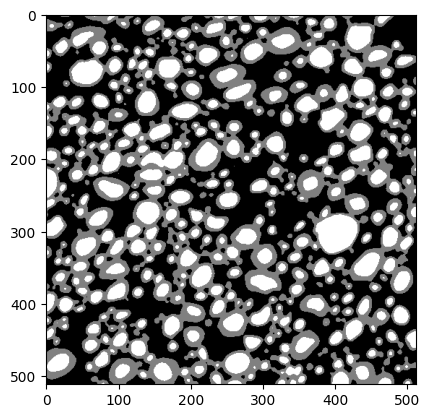

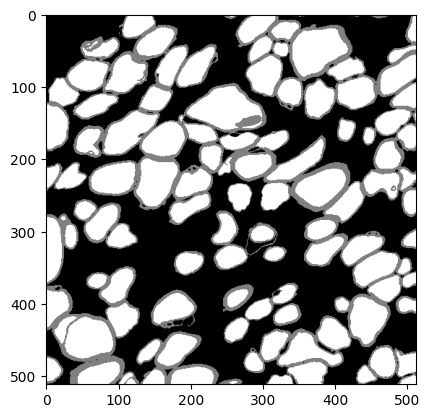

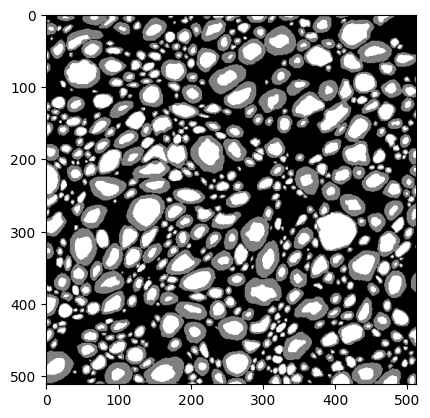

In [17]:
def read_dir(path):
    '''read files from local file system on the path'''
    for file_name in os.listdir(str(path)):
        image = tifffile.imread(str(path.joinpath(file_name)))
        yield file_name, image


data = read_dir(data_path)
for i in range(3):
    _, image = next(data)
    plt.imshow(image, cmap='gray')
    plt.show()

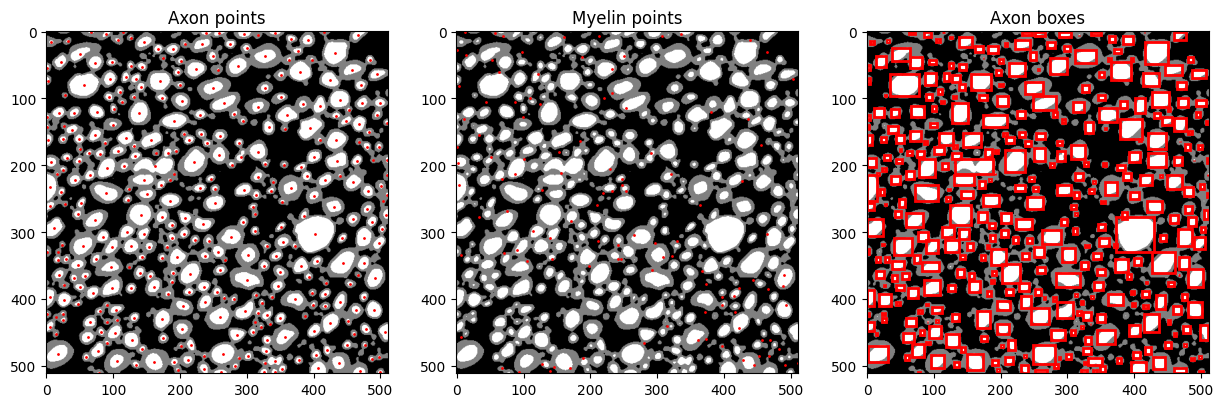

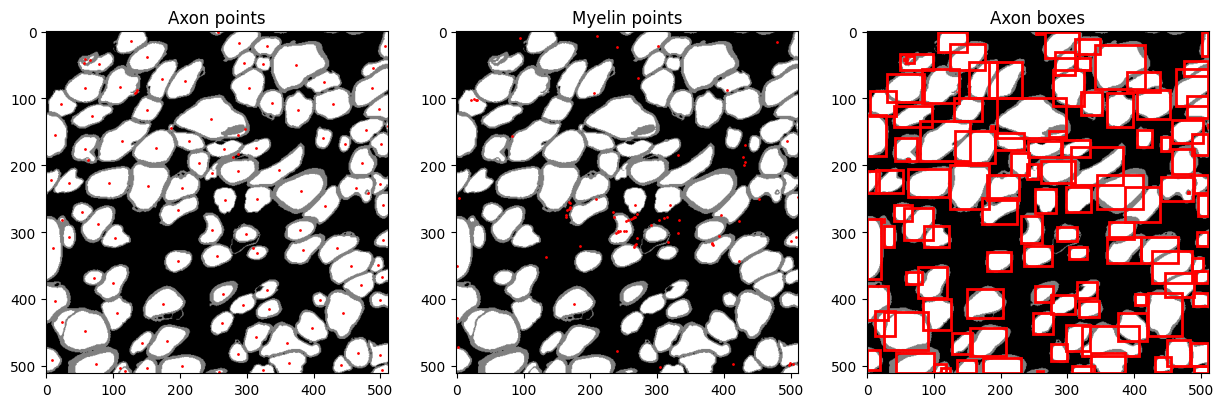

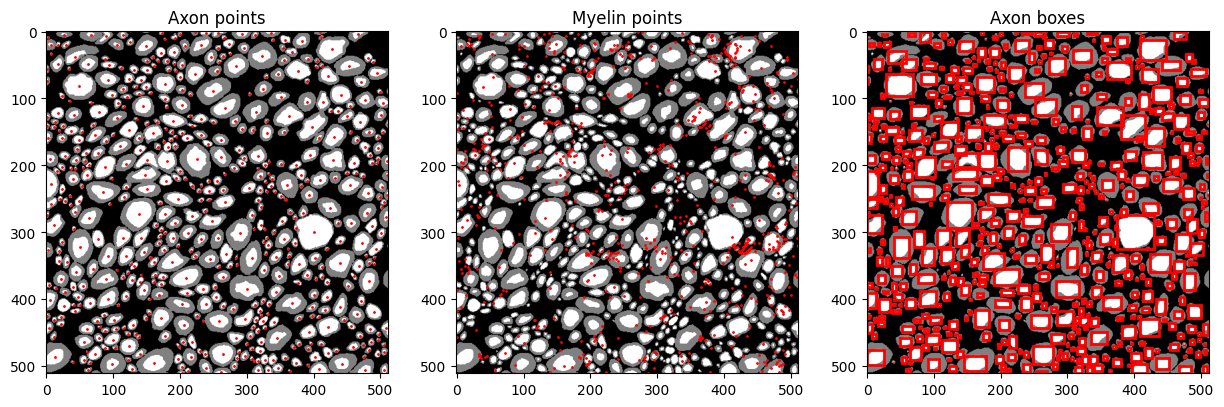

In [18]:
rng = np.random.default_rng()


def get_bounding_box(mask):
    # get bounding box from mask, get minimum and maximum x and y
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    bbox = [x_min, y_min, x_max, y_max]
    return bbox


def get_instance_masks(image):  # used for input while training
    myelin_mask = image == 1
    myelin_instances, num_instances = ndimage.label(myelin_mask)
    axon_mask = image == 2
    axon_instances, _ = ndimage.label(axon_mask)
    axon_instances[axon_instances > 0] += num_instances
    return myelin_instances + axon_instances


def get_boxes_points(image):
    '''find bounding box and point prompt for each instance of axon or myelin when evaluating'''
    axon_boxes = []
    axon_centroids = []
    myelin_points = []  # pick random point on myelin

    axons = image == 2
    labled_array, num_instances = ndimage.label(axons)
    for i in range(1, num_instances + 1):  # 0 is background
        instance_binary_mask = labled_array == i
        axon_centroids.append(ndimage.center_of_mass(instance_binary_mask))
        axon_boxes.append(get_bounding_box(instance_binary_mask))

    myelin = image == 1
    labeled_array, num_instances = ndimage.label(myelin)
    for i in range(1, num_instances + 1):
        instance_binary_mask = labeled_array == i
        myelin_points.append(rng.choice(np.argwhere(instance_binary_mask)))

    return axon_boxes, axon_centroids, myelin_points


data = read_dir(data_path)
for i in range(3):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    _, image = next(data)
    axon_boxes, axon_centroids, myelin_points = get_boxes_points(image)

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Axon points')
    for centroid in axon_centroids:
        axes[0].scatter(centroid[1], centroid[0], c='r', s=1)

    axes[1].imshow(image, cmap='gray')
    axes[1].set_title('Myelin points')
    for point in myelin_points:
        axes[1].scatter(point[0], point[1], c='r', s=1)

    axes[2].imshow(image, cmap='gray')
    axes[2].set_title('Axon boxes')
    for box in axon_boxes:
        axes[2].add_patch(
            Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='r', linewidth=2))


# save instance labelling to folder
data = read_dir(data_path)
for file_name, image in data:
    instance_mask = get_instance_masks(image)
    # make sure instance mask is consecutive
    assert np.isin(np.arange(np.max(instance_mask)), instance_mask).all()
    im = Image.fromarray(instance_mask)
    im.save(str(data_path.parent.joinpath('instance_labeling', file_name)))
    

### Inserting the prompts for training

Copy and modify the training code from train_microsam to use the prompts for each axon and myelin

In [19]:
from pathlib import Path
import numpy as np

import torch

import torch_em
from torch_em.model import UNETR
from torch_em.loss import DiceBasedDistanceLoss
from torch_em.transform.label import PerObjectDistanceTransform

import micro_sam.training as sam_training
from micro_sam.util import export_custom_sam_model

data_path = Path().absolute().joinpath('data')


ModuleNotFoundError: No module named 'torch_em'

In [1]:
def get_dataloader(split, patch_shape, batch_size, train_instance_segmentation):
    assert split in ("train", "val")

    # This will download the image and segmentation data for training.
    image_dir = str(data_path.joinpath('image_tif'))
    segmentation_dir = str(data_path.joinpath('instance_labeling'))

    raw_key, label_key = "*.tif", "*.tif"

    if split == "train":
        roi = np.s_[:150, :, :]
    else:
        roi = np.s_[150:, :, :]

    if train_instance_segmentation:
        # Computes the distance transform for objects to perform end-to-end automatic instance segmentation.
        label_transform = PerObjectDistanceTransform(
            distances=True, boundary_distances=True, directed_distances=False,
            foreground=True, instances=True, min_size=25
        )
    else:
        label_transform = torch_em.transform.label.connected_components

    loader = torch_em.default_segmentation_loader(
        raw_paths=image_dir, raw_key=raw_key,
        label_paths=segmentation_dir, label_key=label_key,
        patch_shape=patch_shape, batch_size=batch_size,
        ndim=2, is_seg_dataset=True, rois=roi,
        label_transform=label_transform,
        num_workers=2, shuffle=True, raw_transform=sam_training.identity,
    )
    return loader


def export_model(checkpoint_name, model_type):
    """Export the trained model."""
    # export the model after training so that it can be used by the rest of the micro_sam library
    export_folder = Path().absolute().joinpath("micro-sam", "examples", "finetuning")
    export_path = export_folder.joinpath("finetuned_hela_model_w_prompting.pth")
    checkpoint_path = export_folder.joinpath("checkpoints", checkpoint_name, "best_w_prompting.pt")
    export_custom_sam_model(
        checkpoint_path=checkpoint_path,
        model_type=model_type,
        save_path=export_path,
    )

In [ ]:
def run_training(checkpoint_name, model_type, train_instance_segmentation=True):
    """Run the actual model training."""

    # All hyperparameters for training.
    batch_size = 1  # the training batch size
    patch_shape = (1, 256, 256)  # the size of patches for training
    n_objects_per_batch = 10  # the number of objects per batch that will be sampled
    device = torch.device("cuda")  # the device/GPU used for training
    n_iterations = 10  # how long we train (in iterations)

    # Get the dataloaders.
    train_loader = get_dataloader("train", patch_shape, batch_size, train_instance_segmentation)
    val_loader = get_dataloader("val", patch_shape, batch_size, train_instance_segmentation)

    # Get the segment anything model
    model = sam_training.get_trainable_sam_model(model_type=model_type, device=device)

    # This class creates all the training data for a batch (inputs, prompts and labels).
    convert_inputs = sam_training.ConvertToSamInputs(transform=model.transform, box_distortion_factor=0.025)

    # Get the optimizer and the LR scheduler
    if train_instance_segmentation:
        # for instance segmentation, we use the UNETR model configuration.
        unetr = UNETR(
            backbone="sam", encoder=model.sam.image_encoder, out_channels=3, use_sam_stats=True,
            final_activation="Sigmoid", use_skip_connection=False, resize_input=True,
        )
        # let's get the parameters for SAM and the decoder from UNETR
        joint_model_params = [params for params in model.parameters()]  # sam parameters
        for name, params in unetr.named_parameters():  # unetr's decoder parameters
            if not name.startswith("encoder"):
                joint_model_params.append(params)
        unetr.to(device)
        optimizer = torch.optim.Adam(joint_model_params, lr=1e-5)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.9, patience=10, verbose=True)

    # the trainer which performs training and validation (implemented using "torch_em")
    if train_instance_segmentation:
        instance_seg_loss = DiceBasedDistanceLoss(mask_distances_in_bg=True)
        trainer = sam_training.JointSamTrainer(
            name=checkpoint_name, train_loader=train_loader, val_loader=val_loader, model=model,
            optimizer=optimizer, device=device, lr_scheduler=scheduler, logger=sam_training.JointSamLogger,
            log_image_interval=100, mixed_precision=True, convert_inputs=convert_inputs,
            n_objects_per_batch=n_objects_per_batch, n_sub_iteration=8, compile_model=False, unetr=unetr,
            instance_loss=instance_seg_loss, instance_metric=instance_seg_loss
        )
    else:
        trainer = sam_training.SamTrainer(
            name=checkpoint_name, train_loader=train_loader, val_loader=val_loader, model=model,
            optimizer=optimizer, device=device, lr_scheduler=scheduler, logger=sam_training.SamLogger,
            log_image_interval=100, mixed_precision=True, convert_inputs=convert_inputs,
            n_objects_per_batch=n_objects_per_batch, n_sub_iteration=8, compile_model=False
        )
    trainer.fit(n_iterations)

In [ ]:
model_type = "vit_b"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_hela_w_prompting"

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
train_instance_segmentation = True

run_training(checkpoint_name, model_type, train_instance_segmentation)
export_model(checkpoint_name, model_type)